# Streamgraph demo

This notebook demonstrates the features of `streamgraph`.

First I'll need to set up some stuff to access the package locally.


In [53]:
%load_ext autoreload
%autoreload 2

import sys, pathlib
repo_root = pathlib.Path("..").resolve()
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Then we do some imports, and set up the aesthetics (cmap, opinionated styling, etc.).

In [ ]:
%%capture
# Imports
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Styling and aesthetics
import opinionated  # Opinionated matplotlib styling
plt.style.use('opinionated_rc')
import colormaps as colormaps 

from pystreamgraph import plot_streamgraph

# Default colormap for this notebook
DEFAULT_CMAP = colormaps.lipari.cut(0.25, 'right')



We load some data: 

In [55]:
# Load sample data
DATA_PATH = os.path.join("..", "data", "sample_streamgraph_data.pkl")
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

## Data Format

The streamgraph library expects data in the following format:

- **X**: 1D array of shape `(n,)` representing the x-axis values (e.g., time points)
- **Y**: 2D array of shape `(k, n)` where:
  - `k` is the number of streams/layers
  - `n` is the number of time points
  - Each row represents one stream's values over time
  - All values should be non-negative
- **labels**: Optional list of `k` strings, one for each stream

The data is stacked vertically to create the streamgraph visualization, with each stream's thickness at any point determined by its corresponding Y value.


In [56]:
X, Y, labels = data['X_stream'][1:], data['Y_stream'][:, 1:], data['cluster_labels_to_plot']

# Display shapes and head using DataFrame (as requested)
# X: (n,), Y: (k, n)
display(pd.DataFrame({"X": X}).head())
df = pd.DataFrame(Y.T, columns=labels)
display(df.head())

n = len(X)
k = Y.shape[0]
print(f"n={n}, k={k}")

X
0  2017.0
1  2018.0
2  2019.0
3  2020.0
4  2021.0

Psychological Science and Methods  Social and political theory  \
0                                 87                           72   
1                                 45                           33   
2                                 63                           38   
3                                 14                           26   
4                                 13                           24   

   Metaphilosophy and Computing  Game Theory and Collective Action  \
0                            32                                 41   
1                            67                                  9   
2                            46                                 19   
3                            31                                 16   
4                            22                                245   

   Philosophy of History  Agent-Based Computational Social Science  \
0                     50                                         1   
1                     12                                         1   
2                     11                                        11   
3                     60                                        20   
4                      2                                        83   

   Cognitive science and NLP  AI Ethics and Interpretability  \
0                         47                               1   
1                         93                               5   
2                         22                              10   
3                         16                              11   
4                         12                              15   

   High-dimensional data visualization  Statistical network analysis  \
0                                    1                             7   
1                                   10                            24   
2                                   44                            32   
3                                   45                            60   
4                                   14                            23   

   Philosophy and Sociology of Science  Social Epistemology of Science  \
0                                    7                               7   
1                                   13                               9   
2                                   22                              13   
3                                   36                              36   
4                                   38                              29   

   Complex systems modeling  Scientometrics and bibliometrics  \
0                        14                                 2   
1                        11                                35   
2                        16                                51   
3                        60                                52   
4                        19                                15   

   NLP for Digital Humanities  
0                           2  
1                           3  
2                          31  
3                          37  
4                          33

n=9, k=15


Helper function to save images:

In [57]:
# Image saving helper
IMAGES_DIR = os.path.join("..", "images")
os.makedirs(IMAGES_DIR, exist_ok=True)

def save_fig(name: str):
    path = os.path.join(IMAGES_DIR, f"{name}.png")
    plt.savefig(path, bbox_inches="tight", dpi=250)
    #print(f"Saved: {path}")


### Basic streamgraph

A minimal example using the library defaults. 

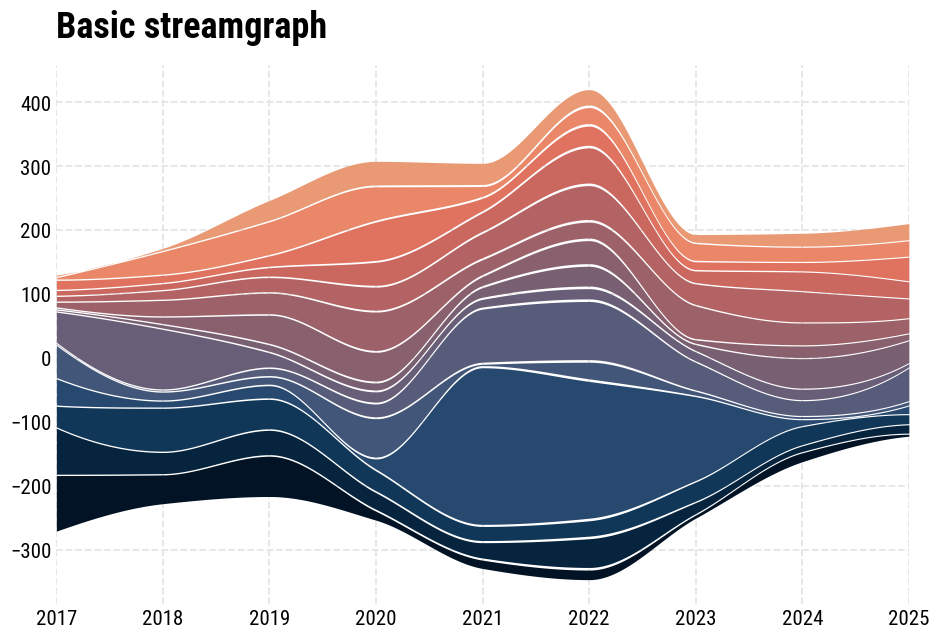

In [58]:
# Basic plot (uses notebook DEFAULT_CMAP)
fig, ax = plt.subplots(figsize=(11, 7))
ax = plot_streamgraph(
    X,
    Y,
    #labels=labels,
    cmap=DEFAULT_CMAP,
    ax=ax,
)
ax.set_title("Basic streamgraph")
save_fig("basic")
plt.show()


### Sorting streams

Use `sorted_streams=True` to order streams by their overall size, which is another common streamgraph layout. Really depends on your data, whether this makes sense. 

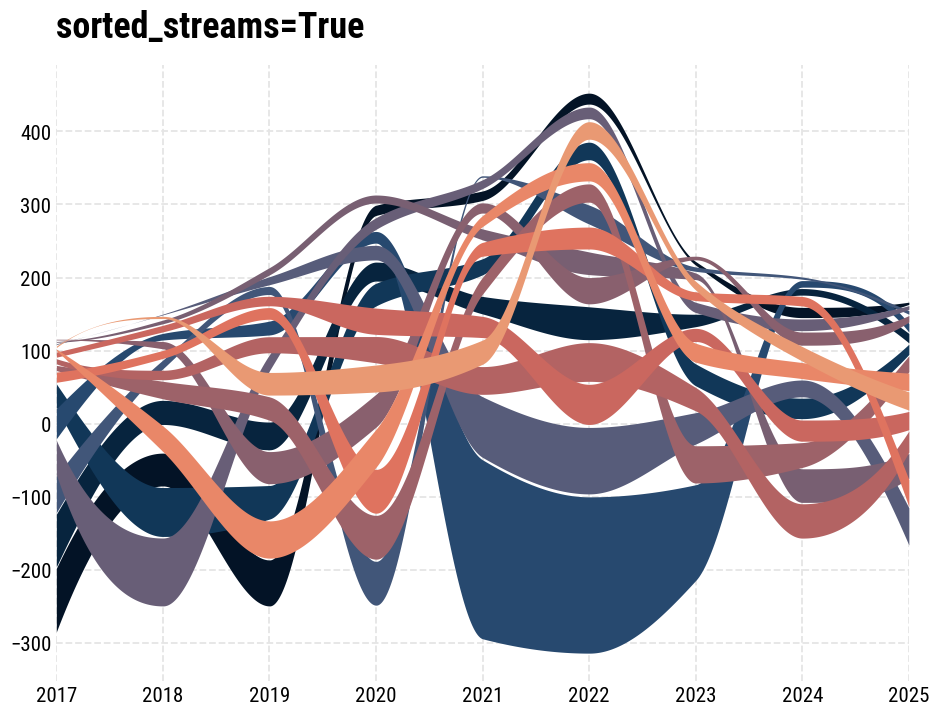

In [ ]:
# Sorted streams: largest-first
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y,  sorted_streams=True, cmap=DEFAULT_CMAP, ax=ax,label_color='black')
ax.set_title("sorted_streams=True")
save_fig("sorting_sorted_true")
plt.show()

### Margins between streams

`margin_frac` controls the vertical spacing between neighboring streams. Higher values separate the layers more, which can improve readability when streams have strong overlaps.

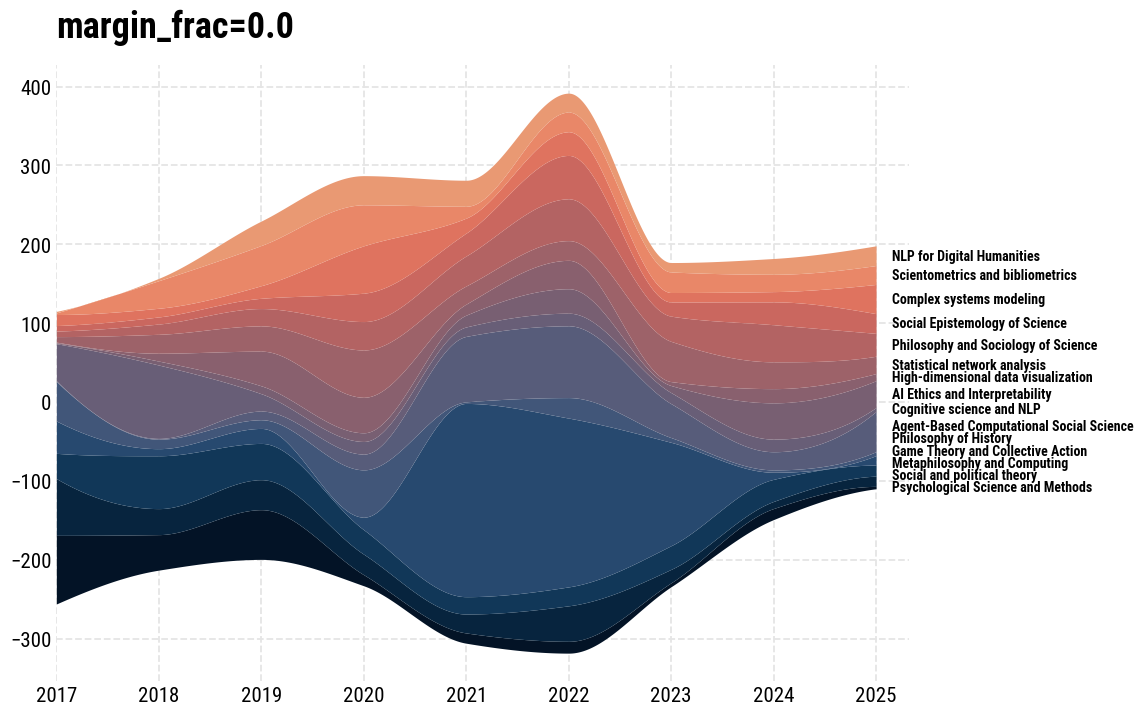

In [60]:
# margin_frac = 0.0 (no gaps)
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y, labels=labels, margin_frac=0.0, cmap=DEFAULT_CMAP, ax=ax,label_color='black')
ax.set_title("margin_frac=0.0")
save_fig("margins_0_00")
plt.show()


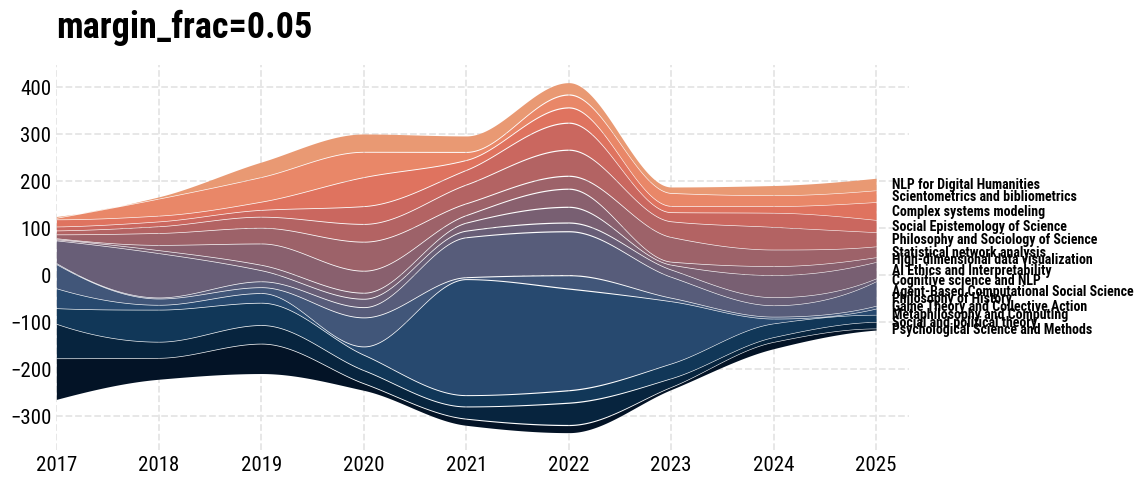

In [61]:
# margin_frac = 0.05 (small gaps)
fig, ax = plt.subplots(figsize=(11, 5))
ax = plot_streamgraph(X, Y, labels=labels, margin_frac=0.05, cmap=DEFAULT_CMAP, ax=ax)
ax.set_title("margin_frac=0.05")
save_fig("margins_0_05")
plt.show()


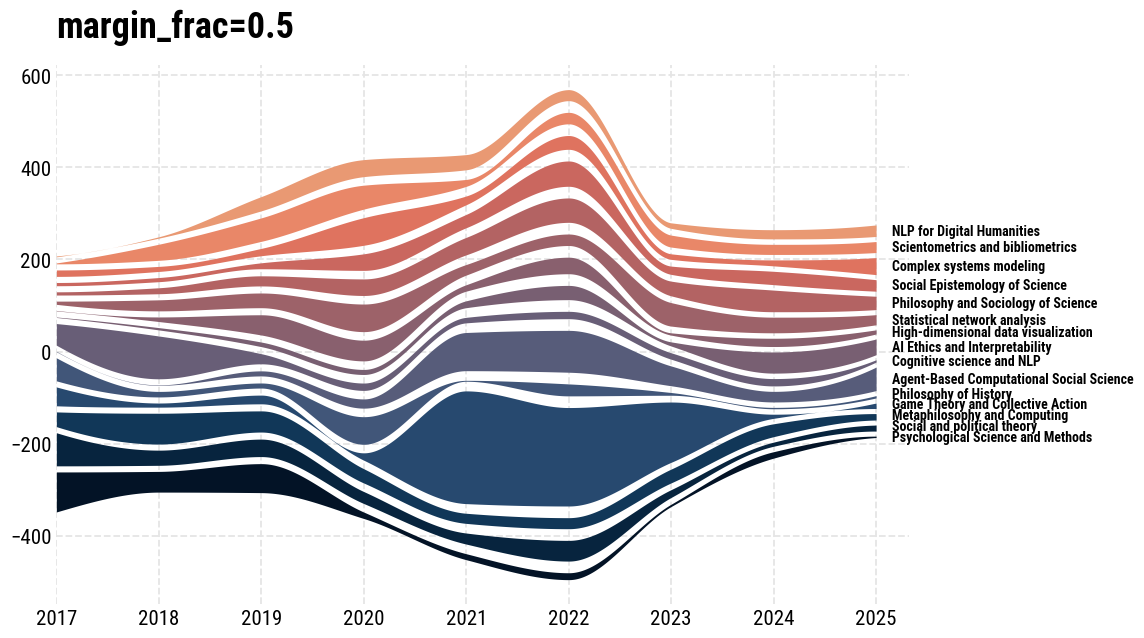

In [ ]:
# margin_frac = 0.5 (large gaps)
fig, ax = plt.subplots(figsize=(11, 7))
ax = plot_streamgraph(X, Y, labels=labels, margin_frac=0.5, cmap=DEFAULT_CMAP, ax=ax)
ax.set_title("margin_frac=0.5")
save_fig("margins_0_50")
plt.show()

### Smoothing (moving average)

`smooth_window` applies a simple moving average along the x-axis. Larger windows can reduce noise and emphasize broader trends. But be careful, too large windows, (e.g. w=7 below) can hide or falsify information. Below we compare a few settings individually.

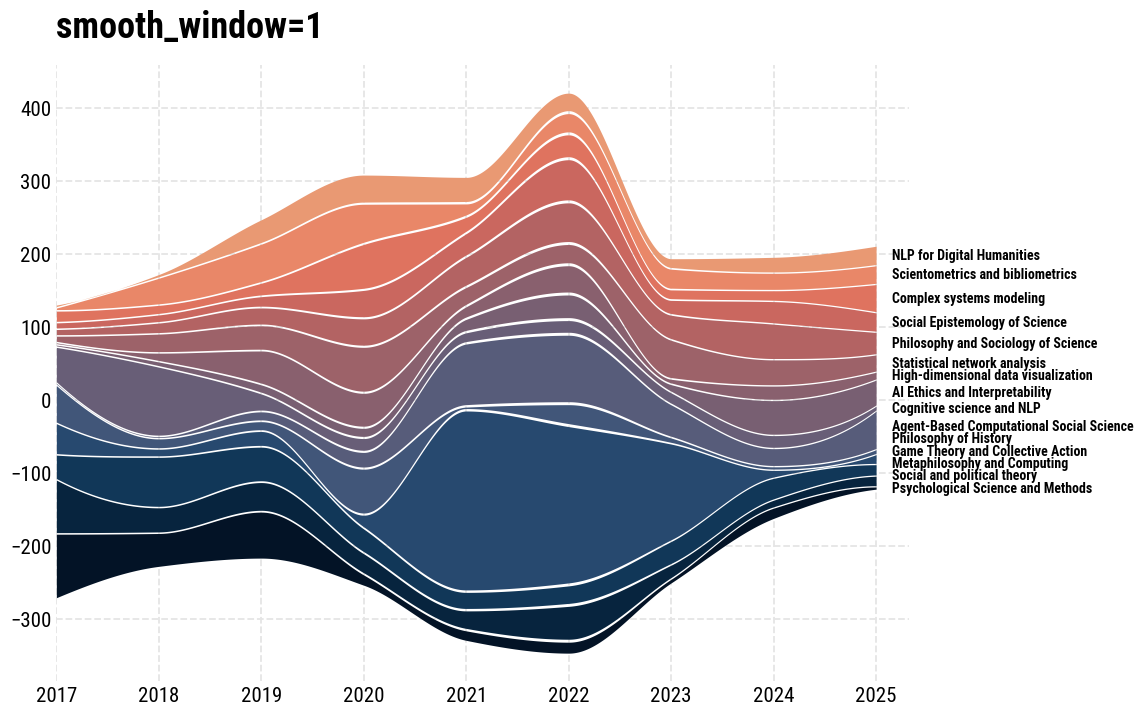

In [ ]:
# smooth_window = 1 (no smoothing)
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y, labels=labels, smooth_window=1, cmap=DEFAULT_CMAP, ax=ax)
ax.set_title("smooth_window=1")
save_fig("smoothing_w1")
plt.show()

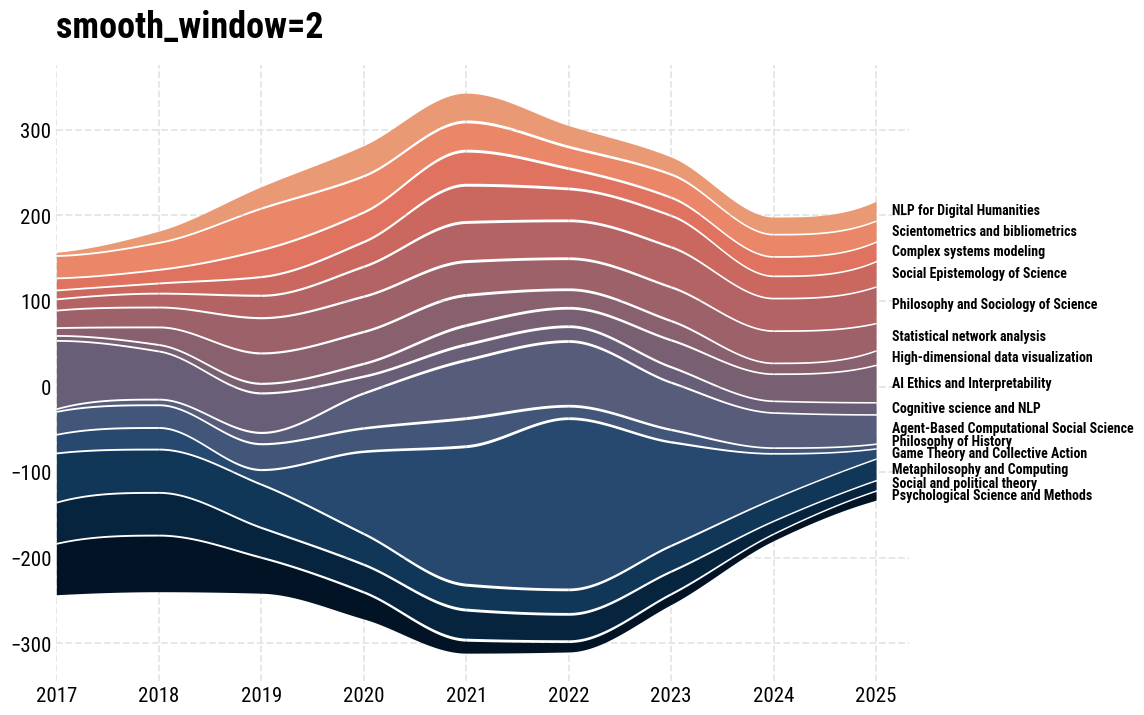

In [ ]:
# smooth_window = 2
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y, labels=labels, smooth_window=2, cmap=DEFAULT_CMAP, ax=ax)
ax.set_title("smooth_window=2")
save_fig("smoothing_w2")
plt.show()

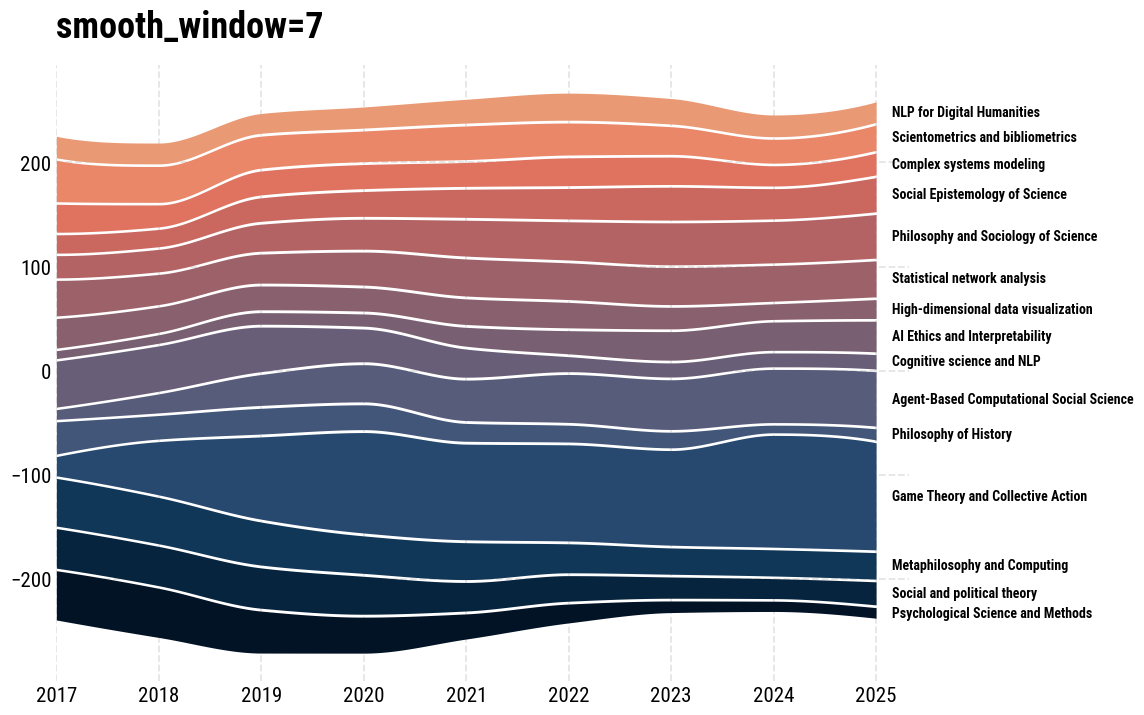

In [ ]:
# smooth_window = 7 (more smoothing)
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y, labels=labels, smooth_window=7, cmap=DEFAULT_CMAP, ax=ax)
ax.set_title("smooth_window=7")
save_fig("smoothing_w7")
plt.show()

### Boundary curve smoothing

`curve_samples` controls how smoothly the stream boundaries are interpolated. Higher values increase smoothness.

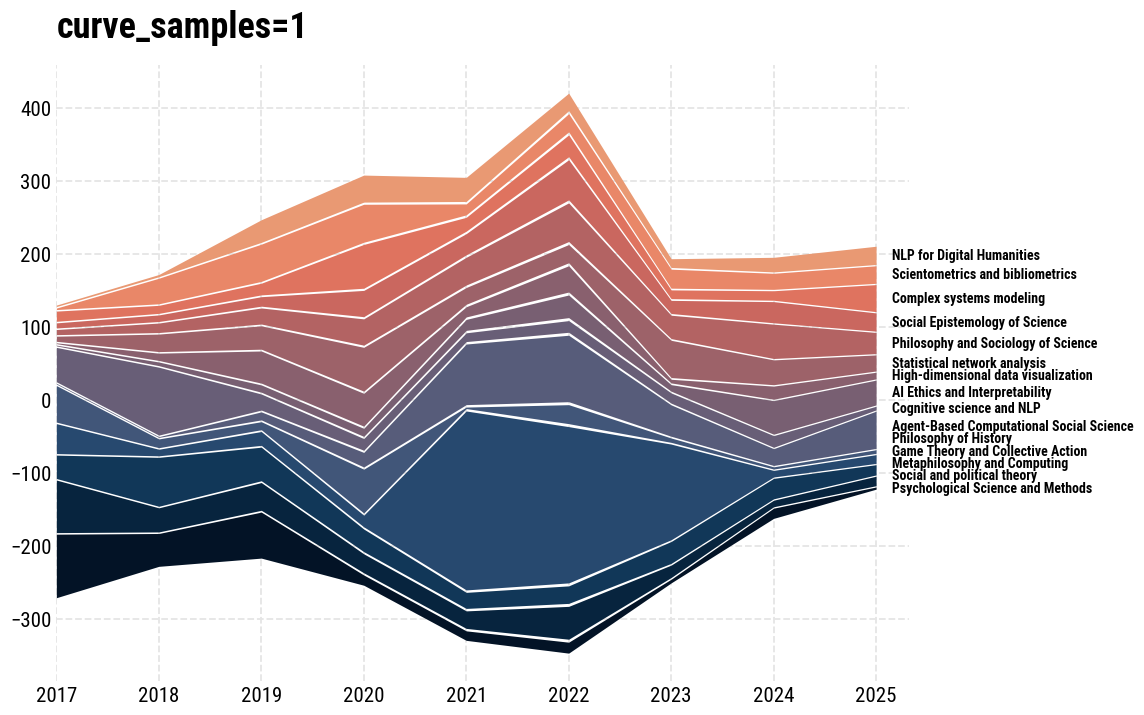

In [66]:
# curve_samples = 1 (least smooth)
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y, labels=labels, curve_samples=1, cmap=DEFAULT_CMAP, ax=ax)
ax.set_title("curve_samples=1")
save_fig("curves_s1")
plt.show()


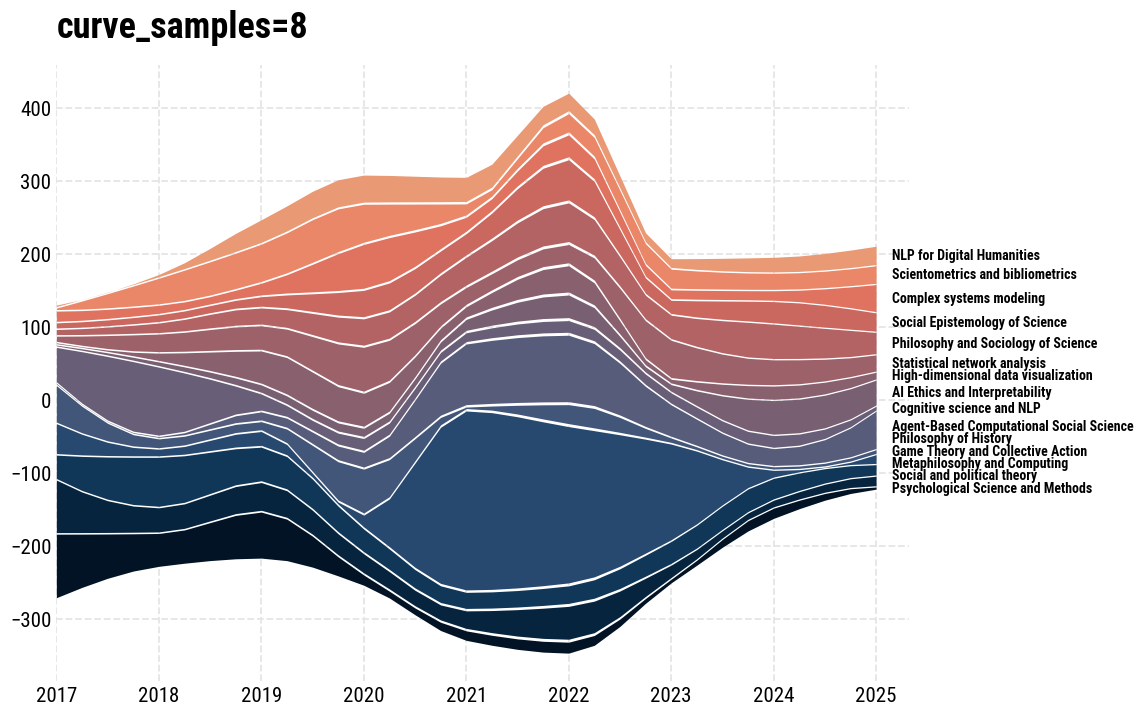

In [ ]:
# curve_samples = 8 (smoother)
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y, labels=labels, curve_samples=3, cmap=DEFAULT_CMAP, ax=ax)
ax.set_title("curve_samples=8")
save_fig("curves_s8")
plt.show()

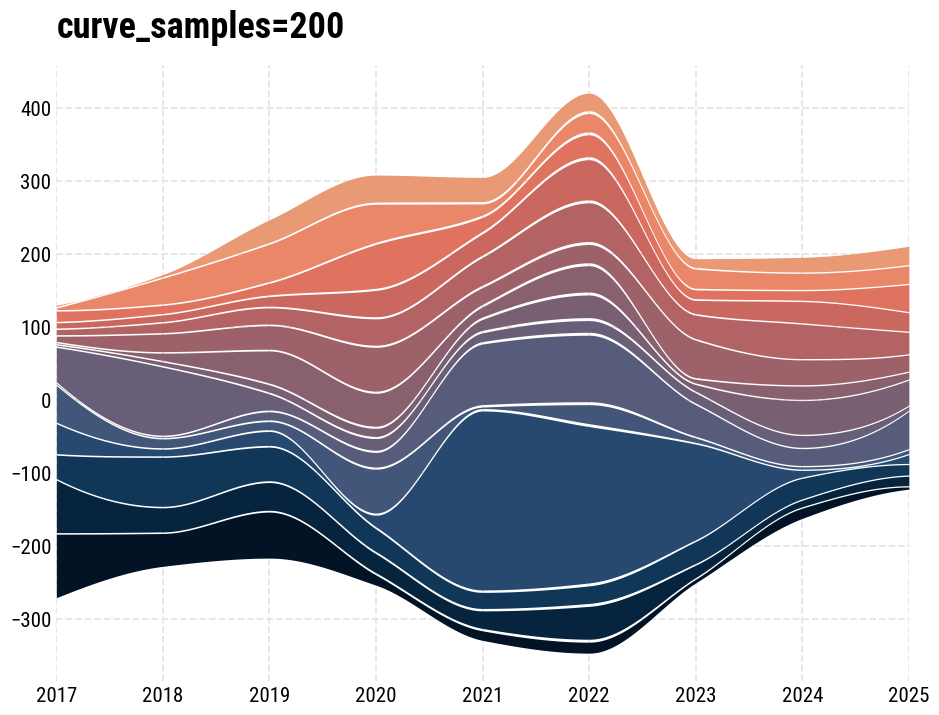

In [68]:
# curve_samples = 200 (very smooth)
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y,curve_samples=200, cmap=DEFAULT_CMAP, ax=ax)
ax.set_title("curve_samples=200")
save_fig("curves_s200")
plt.show()


We have two smoothing modes.  PCHIP-smooting (default), which respects the values well, and Catmull-Rom, which can look nicer, but occasionaly might 'overshoot' while interpolating.

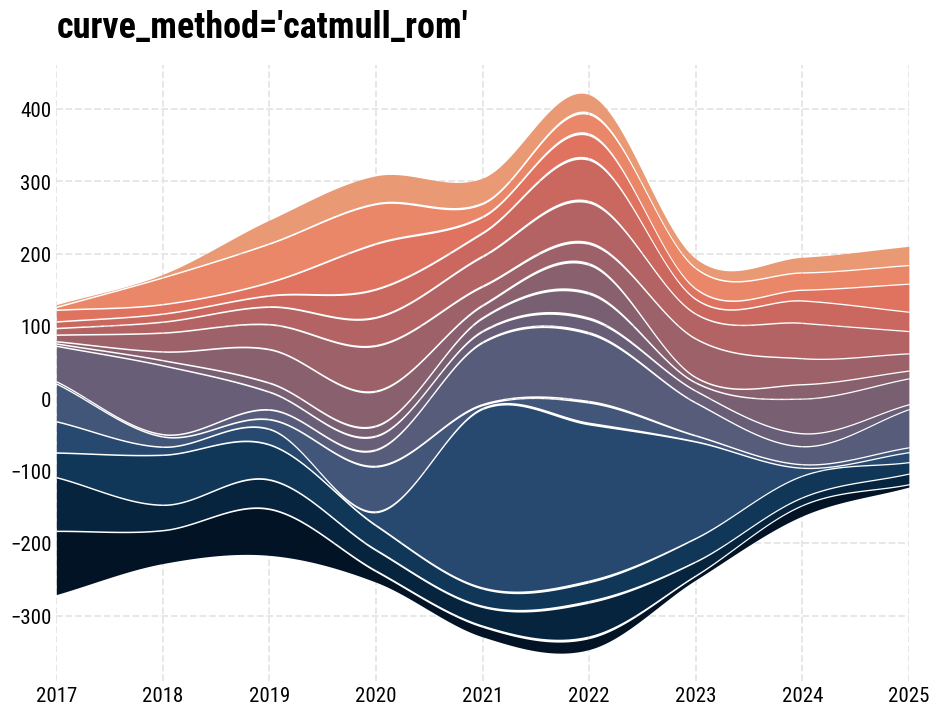

In [69]:
# curve_samples = 200 (very smooth)
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y, curve_method='catmull_rom', curve_samples=200, cmap=DEFAULT_CMAP, ax=ax)
ax.set_title("curve_method='catmull_rom'")
save_fig("curves_s200")
plt.show()


### Label placement modes

The `label_position` option places labels by different heuristics:
- `peak`: at each stream’s local maximum
- `start`: at the left edge
- `end`: at the right edge
- `max_width: placed on top of the widest part of the plot.
- `balanced`: Optimized layout accross the plot that minimizes overlap among labels and with the margins, and tries to put labels in an even spread on the widest parts of each stream.

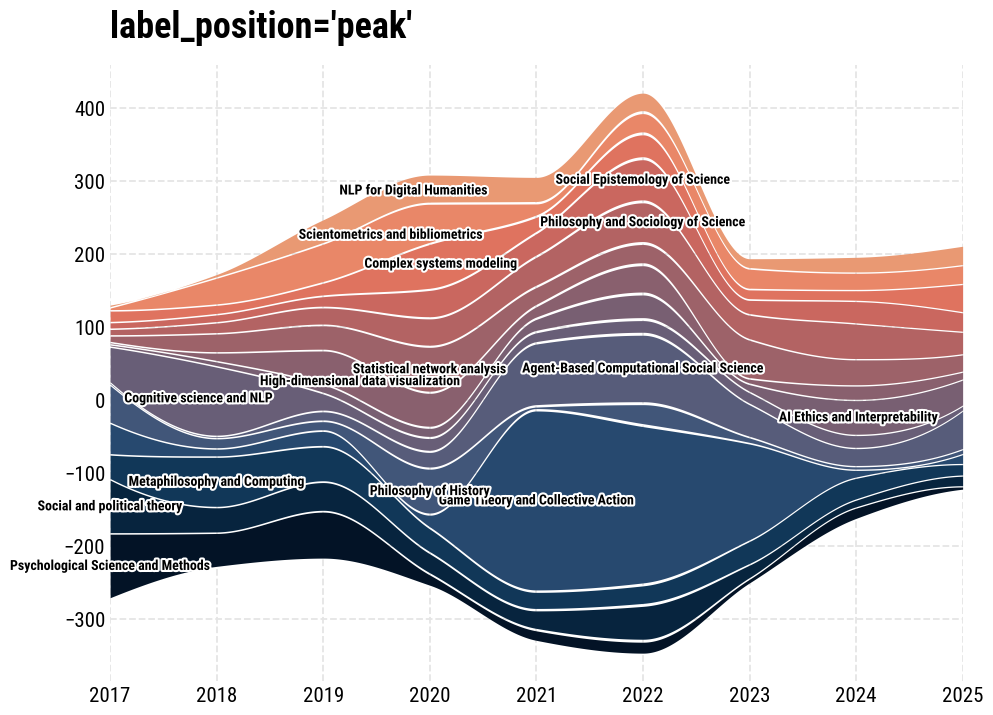

In [70]:
# label_position = 'peak'
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y, labels=labels, label_position='peak', cmap=DEFAULT_CMAP, ax=ax,label_color='black',label_kwargs={'path_effects': [path_effects.withStroke(linewidth=3, foreground='white')]})
ax.set_title("label_position='peak'")
save_fig("labels_position_peak")
plt.show()


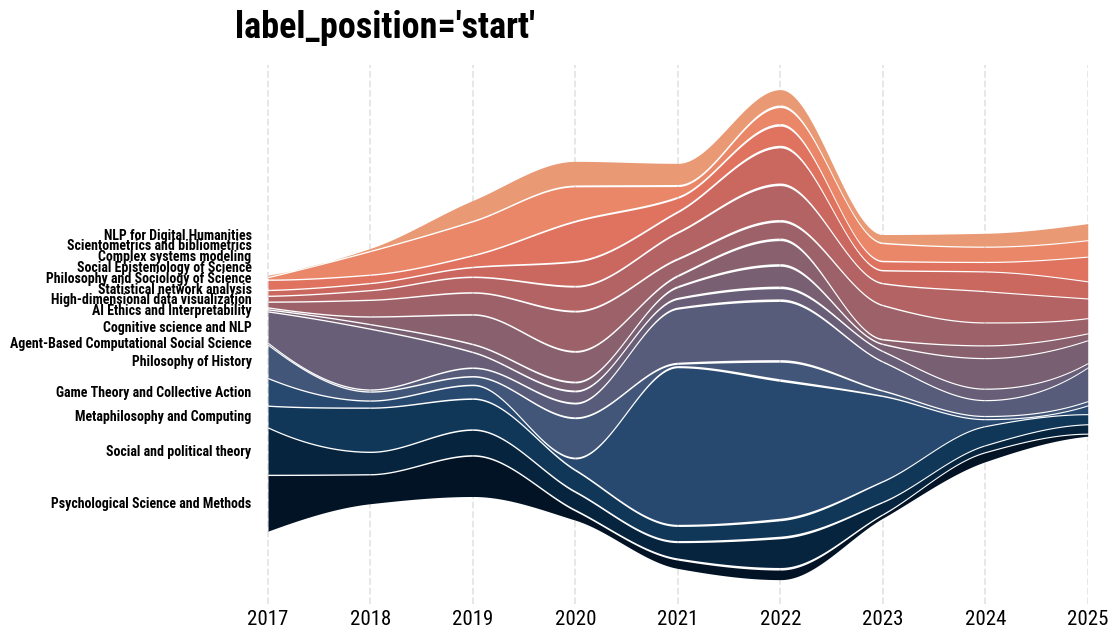

In [71]:
# label_position = 'start'
fig, ax = plt.subplots(figsize=(11, 7))
ax = plot_streamgraph(X, Y, labels=labels, label_position='start', cmap=DEFAULT_CMAP, ax=ax,label_color='black')
ax.set_yticks([])
ax.set_ylabel('')

ax.set_title("label_position='start'")
save_fig("labels_position_start")
plt.show()


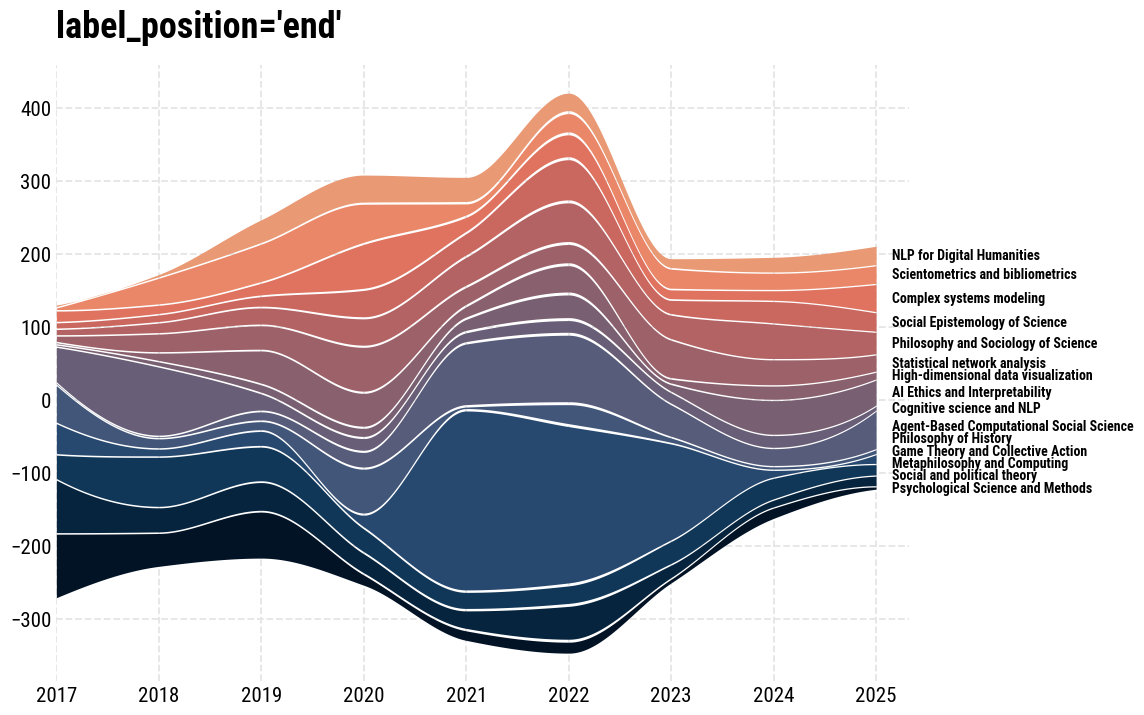

In [72]:
# label_position = 'end'
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y, labels=labels, label_position='end', cmap=DEFAULT_CMAP, ax=ax,label_color='black')
ax.set_title("label_position='end'")
save_fig("labels_position_end")
plt.show()


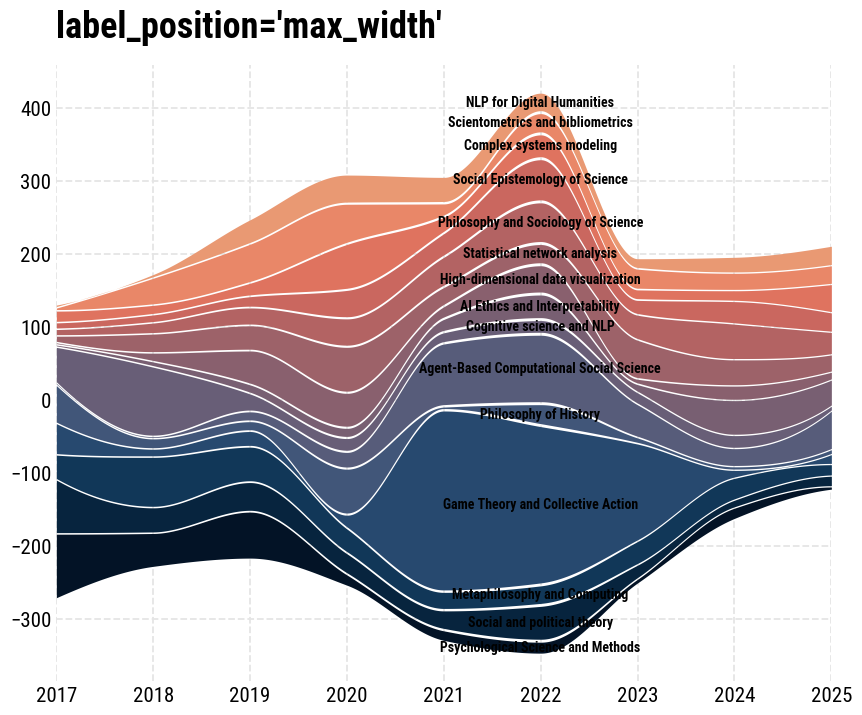

In [73]:
# label_position='max_width'
fig, ax = plt.subplots(figsize=(10, 8))
ax = plot_streamgraph(X, Y, labels=labels, label_position='max_width',ax=ax,label_color='black',cmap=DEFAULT_CMAP)
ax.set_title("label_position='max_width'")
save_fig("labels_max_width")
plt.show()


Balancing labels:   0%|          | 0/138 [00:00<?, ?it/s]

Balancing labels:   0%|          | 0/138 [00:00<?, ?it/s]

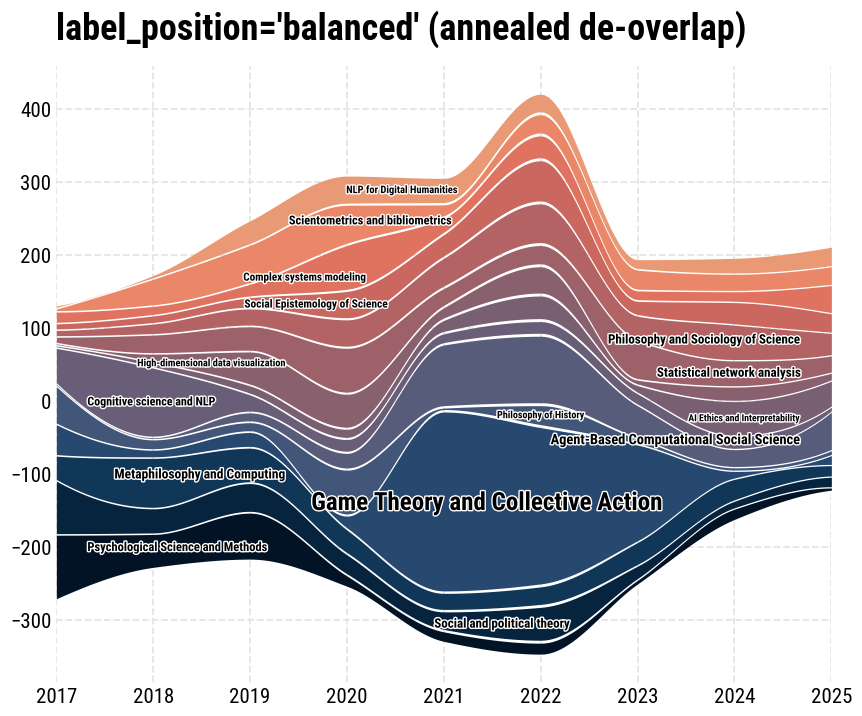

In [74]:
# Balanced label placement demo with enhanced styling
fig, ax = plt.subplots(figsize=(10, 8))

# Configure path effects for better label readability
stroke_effect = path_effects.withStroke(linewidth=2, foreground='white')
bbox_style = dict(
    boxstyle="round,pad=0.3", 
    alpha=0., 
    edgecolor='none'
) # We can add a bbox to get padding between the labels.

ax = plot_streamgraph(
    X, Y, 
    labels=labels, 
    cmap=DEFAULT_CMAP,
    sorted_streams=False,  # Keep original stream order
    label_position='balanced',  # Use annealed placement to avoid overlaps
    label_balanced_inset_frac=0.02,  # Keep labels slightly inside stream boundaries
    curve_samples=24,  # Smooth curve interpolation
    label_fontsize_min=7,  # Minimum font size for smaller streams
    label_fontsize_max=18,  # Maximum font size for larger streams
    label_color='black',
    label_kwargs={
        'path_effects': [stroke_effect],  # White outline for better contrast
        'bbox': bbox_style  # Semi-transparent white background box
    },
    label_anchor='middle_center',
    #label_balanced_debug_segments=True,
    ax=ax,
    label_balanced_progress=True # Monitor the annealing progress of the label-placement.
)

ax.set_title("label_position='balanced' (annealed de-overlap)")
save_fig("labels_balanced")
plt.show()

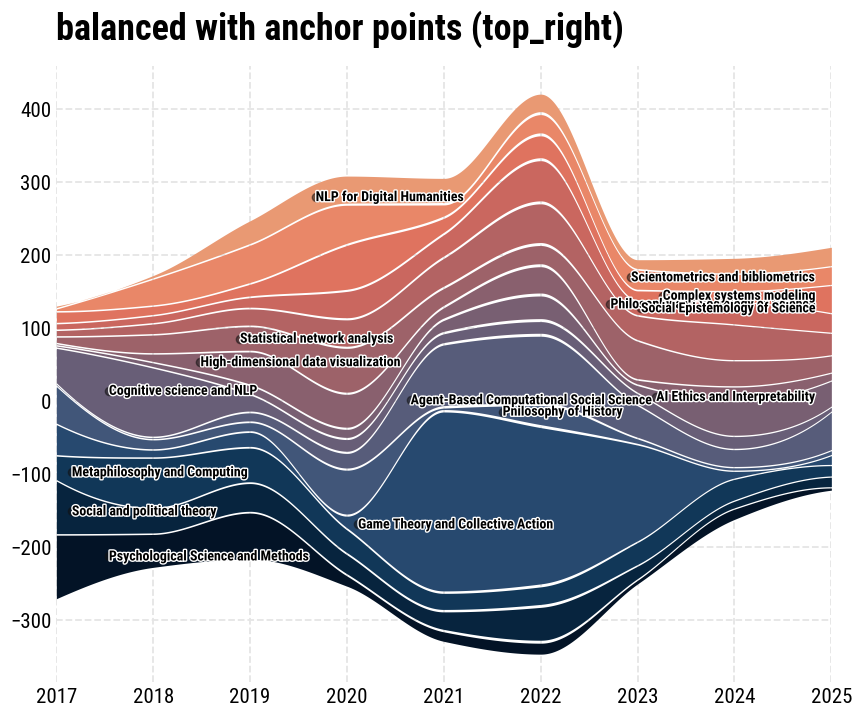

In [75]:
# Balanced with anchors shown, top_right anchor
fig, ax = plt.subplots(figsize=(10, 8))
ax = plot_streamgraph(
    X, Y, labels=labels, cmap=DEFAULT_CMAP,
    label_position='balanced',
    label_balanced_inset_frac=0.01,  # Keep labels slightly inside stream boundaries

    label_anchor='middle_left',
    label_plot_anchors=True,
    label_point_kwargs={"markersize": 6, "color": "#111"},
    label_color='black',
    label_kwargs={
        'path_effects': [stroke_effect],  # White outline for better contrast
        'bbox': bbox_style  # Semi-transparent white background box
    },
    ax=ax
)
ax.set_title("balanced with anchor points (top_right)")
save_fig("labels_balanced_with_anchors")
plt.show()


### Color options

There are various ways to set streamgraph-colors. Above we have always simply used a colormap directly. But you can also provide a name of a matplotlib-cmap:

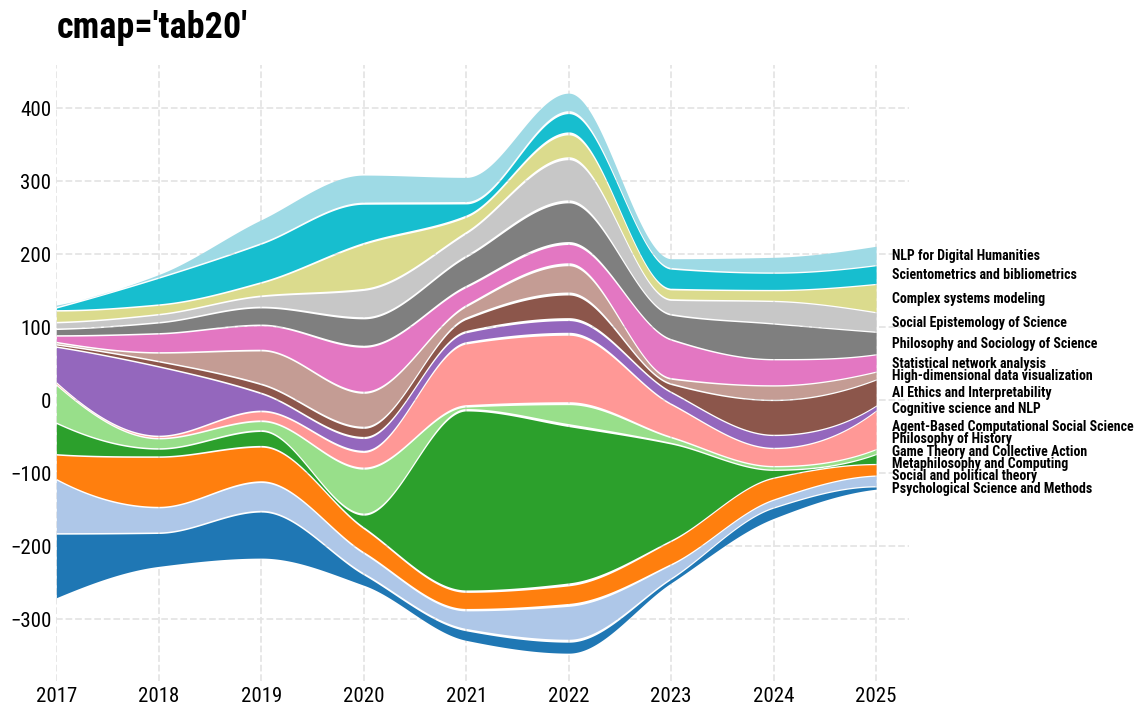

In [76]:
# cmap as named matplotlib colormap
fig, ax = plt.subplots(figsize=(11, 8))
ax = plot_streamgraph(X, Y, labels=labels, cmap='tab20',ax=ax,label_color='black')
ax.set_title("cmap='tab20'")
save_fig("colormaps_named_tab20")
plt.show()


...or an explicit list of colors:

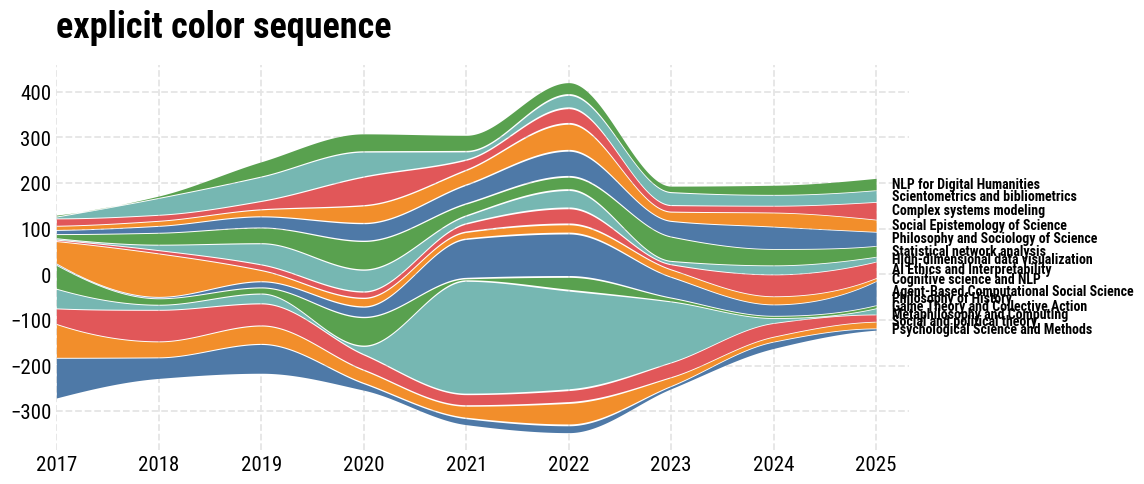

In [77]:
# cmap as explicit color sequence (cycled)
fig, ax = plt.subplots(figsize=(11, 5))
seq = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F"]
ax = plot_streamgraph(X, Y, labels=labels, cmap=seq,ax=ax,label_color='black')
ax.set_title("explicit color sequence")
save_fig("colormaps_sequence")
plt.show()


... or a dictionary of labels to colors, for even more fine-grained control. Note that you can also pass a list of colors to label_color!

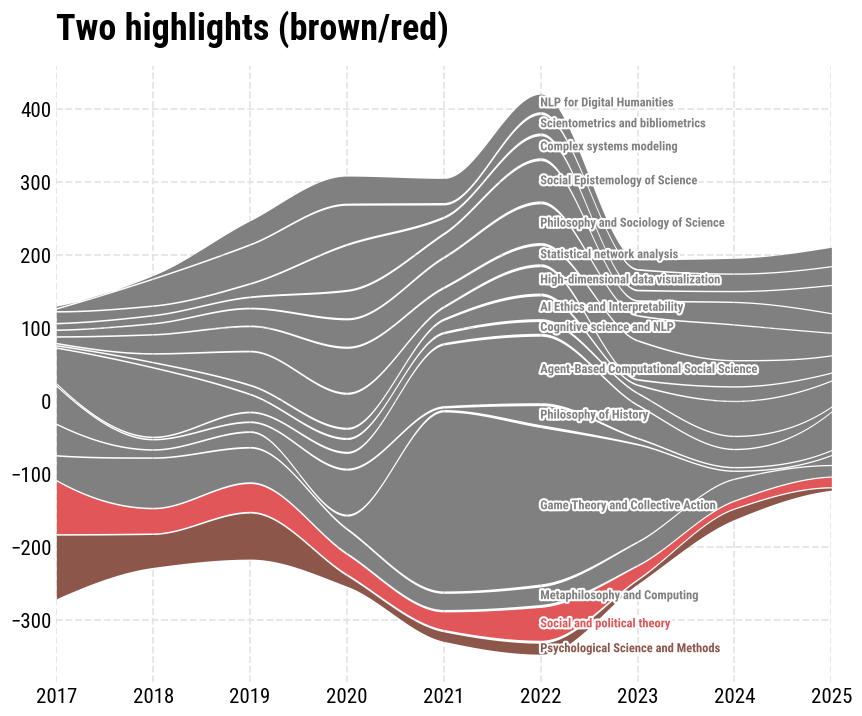

In [78]:
# highlight two labels, others default
fig, ax = plt.subplots(figsize=(10, 8))
map_colors = {labels[0]: "#8c564b", labels[1]: "#e15759"}
for i in range(2, len(labels)):
    map_colors[labels[i]] = "#808080"
    
    
ax = plot_streamgraph(
    X, Y, labels=labels, cmap=map_colors,
    label_position='max_width', label_kwargs={"fontsize": 9,'path_effects': [path_effects.withStroke(linewidth=3, foreground='white')]}, ax=ax,label_color=[map_colors[x] for x in labels],
    label_anchor='middle_left',
)
ax.set_title("Two highlights (brown/red)")
save_fig("colormaps_mapping_grey")
plt.show()


### Further appearance tweaks

Adjust the stream outlines and transparency with `linewidth` and `alpha`, and control padding between stacks with `pad_frac`.


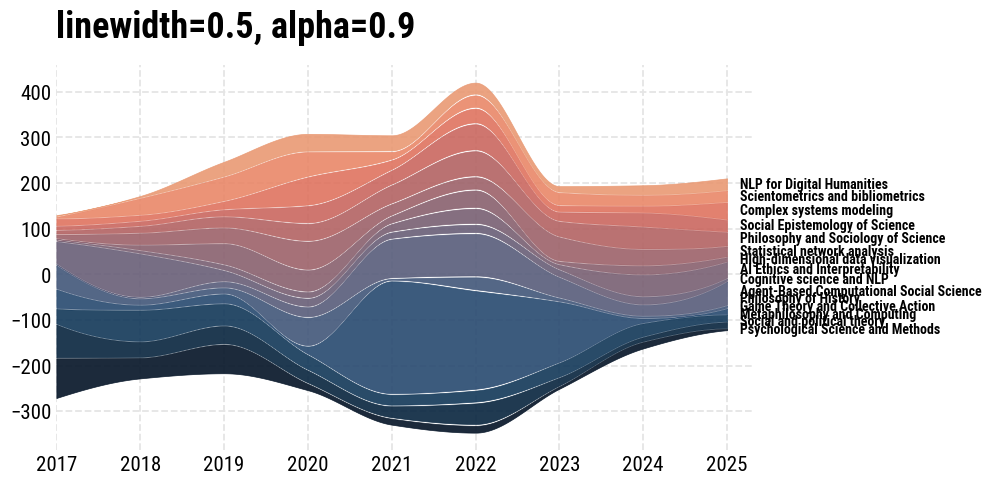

In [79]:
# linewidth=0.5, alpha=0.9
fig, ax = plt.subplots(figsize=(9, 5))
ax = plot_streamgraph(X, Y, labels=labels, linewidth=0.5, alpha=0.9, cmap=DEFAULT_CMAP, ax=ax)
ax.set_title("linewidth=0.5, alpha=0.9")
save_fig("appearance_line_alpha_1")
plt.show()


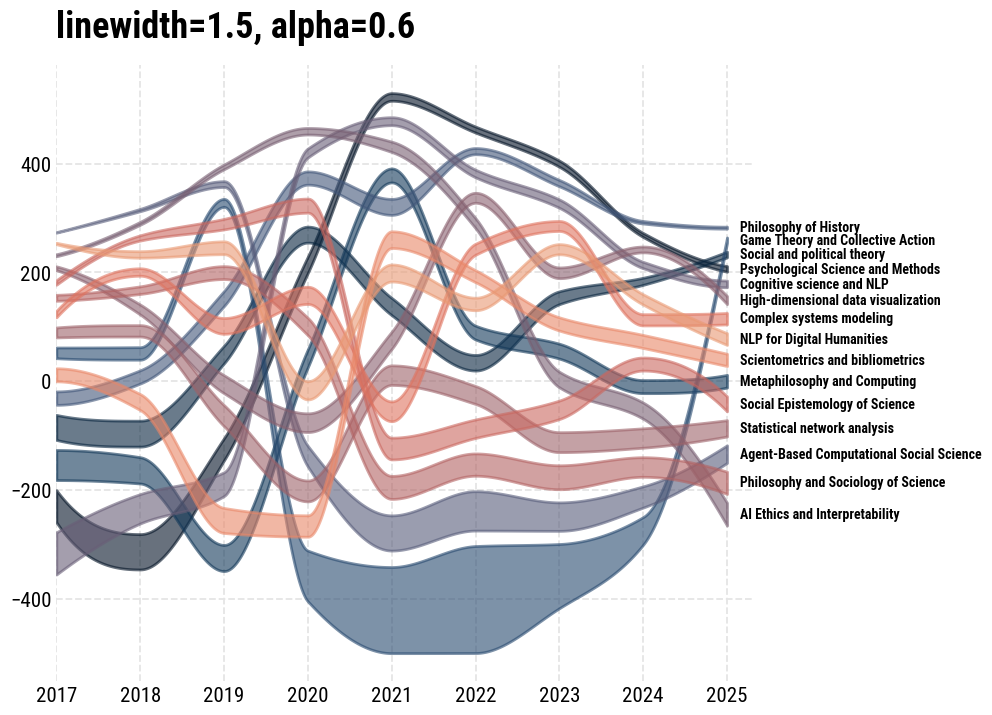

In [80]:
# linewidth=1.5, alpha=0.6
fig, ax = plt.subplots(figsize=(9, 8))
ax = plot_streamgraph(X, Y, labels=labels,sorted_streams=True, linewidth=2, alpha=0.6, cmap=DEFAULT_CMAP, ax=ax,label_color='black', margin_frac=0.7,smooth_window=3)
ax.set_title("linewidth=1.5, alpha=0.6")
save_fig("appearance_line_alpha_2")
plt.show()


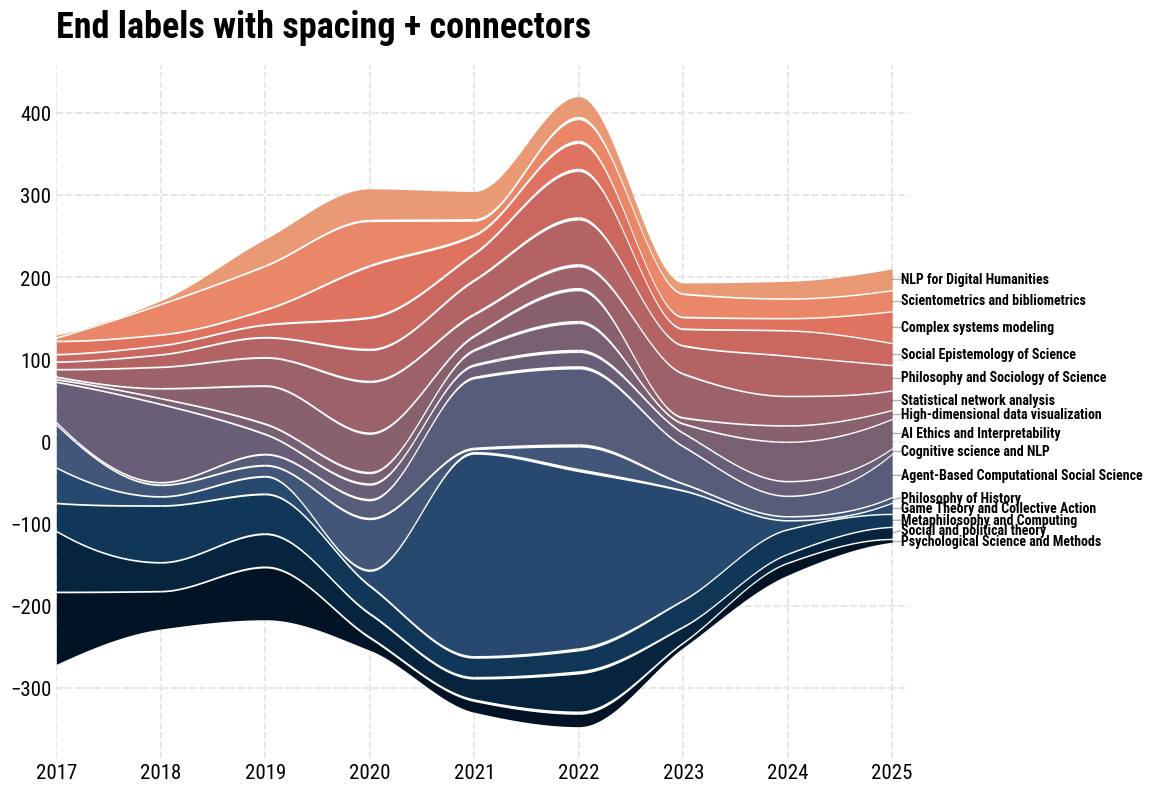

In [81]:
# End labels with spacing + connectors
fig, ax = plt.subplots(figsize=(11, 9))
ax = plot_streamgraph(
    X, Y, labels=labels,
    ax=ax,
    cmap=DEFAULT_CMAP,
    label_position='end',
    label_min_gap_frac=0.015,
    label_edge_offset_frac=0.01,
    label_connectors=True,
    label_connector_alpha=0.3,
    label_connector_linewidth=1.0,
    label_color='black',
    
)
ax.set_title("End labels with spacing + connectors")
save_fig("labels_end_spacing_connectors")
plt.show()


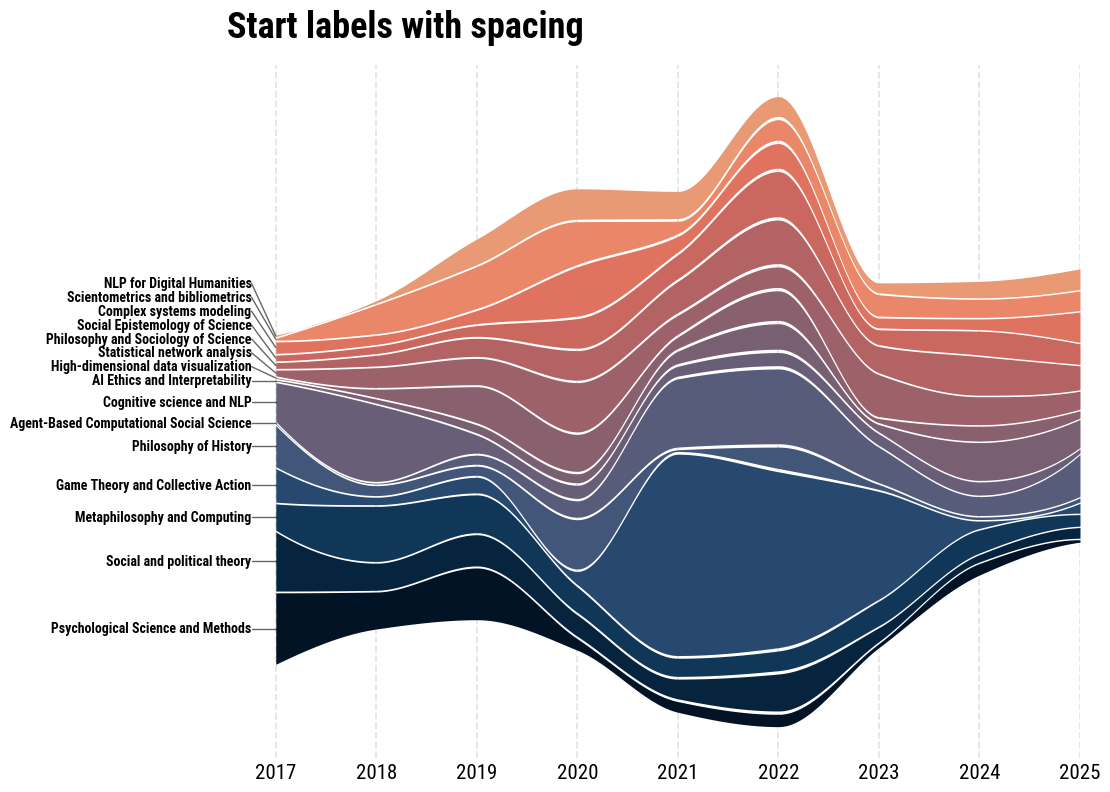

In [82]:
# Start labels with spacing
fig, ax = plt.subplots(figsize=(11, 9))
ax = plot_streamgraph(
    X, Y, labels=labels,
    label_position='start',
    label_min_gap_frac=0.02,
    label_edge_offset_frac=0.03,
        label_connector_linewidth=1.0,
    label_color='black',
        label_connectors=True,
    cmap=DEFAULT_CMAP,
    ax=ax,
)
ax.set_yticks([])
ax.set_ylabel('')
ax.set_title("Start labels with spacing")
save_fig("labels_start_spacing")
plt.show()


# Base example 

Basic self contained example for the Quick-start.

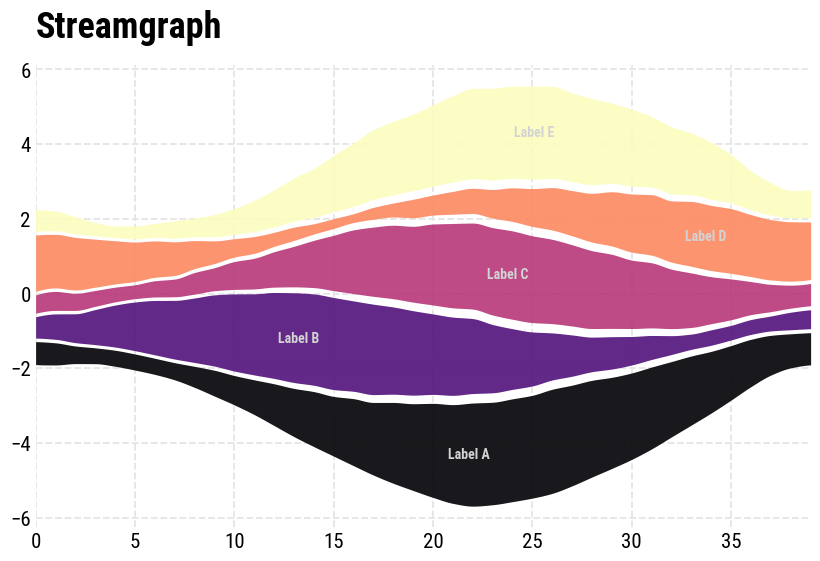

In [ ]:
# import numpy as np
import matplotlib.pyplot as plt
from pystreamgraph import plot_streamgraph

rng = np.random.default_rng(7)
n, k = 40, 5
X_ = np.arange(n)
base = np.linspace(0, 2*np.pi, n)
Y_ = []
for i in range(k):
    phase = rng.uniform(0, 2*np.pi)
    amp = rng.uniform(0.6, 1.3)
    y = amp * (np.sin(base + phase) + 1.2) + rng.normal(0, 0.08, size=n) + 0.15
    y = np.clip(y, 0, None)
    Y_.append(y)
Y_ = np.vstack(Y_)

ax = plot_streamgraph(X_, Y_, labels=['Label ' + x for x in list("ABCDE")], sorted_streams=False,
                      margin_frac=0.10, smooth_window=3, cmap='magma',
                      curve_samples=40,alpha=0.9,label_color='lightgrey',label_placement=True,label_position='balanced')
ax.set_title("Streamgraph")
save_fig("streamgraph_base")
plt.show()